Вариационная модель звезды

Как параметр задана масса звезды M.
Звезда разбита на N сферических слоев.
Также задано распределение водорода по слоям.
Имеется N+1 точка - расстояния от центра до i-го слоя.
Неизвестными являются массивы расстояний r[i] и температур t[i]

Date of creation: 2.07.2020

Last updated: 3.07.2020

In [17]:
import math
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

In [18]:
import NotebookLoader
import Physics as ph
import SSM18 as s

In [19]:
pi = math.pi
# K = 6 # number of interpolated layers
# dimM = 17*K+1 # N+1 - число точек модели (сферических слоев + 1)
Z = s.Z

In [25]:
def Opacity(den, T, X, Y, Z):
    T0 = 2e6
    return 0.4 + 2.3*(1 - math.exp(-pow(T/T0, 9/2)))*7e22*den*pow(T, -7/2)*(X + Y)*(X + 0.5*Y)

In [103]:
# df1 = s.load_interpolated_data(K)
def load_model(epoch):
#     filename = 'FromCenter/1epoch%.02d.csv' % epoch
    filename = 'Mass/3epoch%.02d.csv' % epoch
    return pd.read_csv(filename)
epoch = 1
df1 = load_model(epoch)
dimM = len(df1.index)
df1

,Unnamed: 0,Mass,Radius,Temperature,Density,Luminosity,Hydrogen,Opacity,Pressure,Velocity
0,0,0.000000e+00,0.000000e+00,1.476102e+07,95.295625,0.000000e+00,0.648658,1.390872,1.809783e+17,1.257492e-10
1,1,1.990588e+30,1.708467e+09,1.463609e+07,94.237343,3.113680e+31,0.652529,1.411856,1.780057e+17,1.192188e-10
2,2,3.981176e+30,2.156555e+09,1.455812e+07,93.620852,6.103297e+31,0.654702,1.425568,1.762054e+17,1.154029e-10
3,3,5.971765e+30,2.471982e+09,1.449126e+07,93.102711,9.011494e+31,0.656470,1.437577,1.746720e+17,1.122645e-10
4,4,7.962353e+30,2.723875e+09,1.443079e+07,92.637631,1.185084e+32,0.658008,1.448599,1.732866e+17,1.095219e-10
...,...,...,...,...,...,...,...,...,...,...
996,996,1.982626e+33,4.110901e+10,9.075170e+05,0.204089,3.337344e+33,0.732000,2.761272,2.542492e+13,1.093885e-21
997,997,1.984616e+33,4.156326e+10,8.019864e+05,0.167307,3.337344e+33,0.732000,2.357034,1.841899e+13,2.418664e-22
998,998,1.986607e+33,4.210426e+10,6.822346e+05,0.125576,3.337344e+33,0.732000,1.881852,1.176054e+13,3.269625e-23
999,999,1.988598e+33,4.280412e+10,5.331910e+05,0.075531,3.337344e+33,0.732000,1.297275,5.528353e+12,1.442041e-24


In [104]:
x = df1['Hydrogen'].values
m = df1['Mass'].values
d = df1['Density'].values
t = df1['Temperature'].values
# The rest may be computed from the above variables.
# r = df1['Radius'].values
# l = df1['Luminosity'].values
# p = df1['Pressure'].values
# k = df1['Opacity'].values
# c = df1['Convection'].values
# v = df1['Velocity'].values

In [105]:
r = np.zeros(dimM)
l = np.zeros(dimM)
p = np.zeros(dimM)
k = np.zeros(dimM)
# c = np.zeros(dimM)
v = np.zeros(dimM)

In [106]:
# Вычисляем величины r,l,p,k,c,v из x,m,d,t
r[0] = 0.
l[0] = 0.
for i in range(1, dimM):
    r[i] = pow(pow(r[i-1], 3) + 3*(m[i] - m[i-1])/4/pi/d[i-1], 1/3) 
    l[i] = l[i-1] + (m[i] - m[i-1])*ph.Etot(0.5*(d[i]+d[i-1]), 0.5*(t[i]+t[i-1]), x[i], 1 - Z - x[i], Z)
for i in range(dimM):
    X = x[i]
    Y = 1 - Z -X
    p[i] = ph.Pressure(d[i], t[i], X, Y, Z)
    k[i] = Opacity(d[i], t[i], X, Y, Z)
    v[i] = 4*ph.m_prot*ph.Etot(d[i], t[i], X, Y, Z)/X/ph.dEpp*ph.year

In [107]:
# Вычисляем новые содержание водорода через 1 млрд лет.
x1 = x*np.exp(-1e9*v)
x1

array([0.57200979, 0.57919399, 0.58334449, ..., 0.732     , 0.732     ,
       0.732     ])

In [82]:
dfx = pd.DataFrame({'Epoch00': x, 'Epoch01': x1})
dfx

,Epoch00,Epoch01
0,0.648658,0.572476
1,0.652529,0.579661
2,0.654702,0.583825
3,0.656470,0.587254
4,0.658008,0.590259
...,...,...
996,0.732000,0.732000
997,0.732000,0.732000
998,0.732000,0.732000
999,0.732000,0.732000


In [97]:
_ = dfx.to_csv(line_terminator='\n')
filename = "Mass/hydrogen.csv"
print(filename)
csv_file = open(filename, "wt")
n = csv_file.write(_)
csv_file.close()

Mass/hydrogen.csv


In [108]:
e = np.zeros(dimM) # энерговыделения
a = np.zeros(dimM) # градиент давления
da = np.zeros(dimM) # несоответствие градиента давления
b = np.zeros(dimM) # градиент температуры
br = np.zeros(dimM) # градиент температуры при радиации
bc = np.zeros(dimM) # градиент температуры при конвекции
db = np.zeros(dimM) # несоответствие градиента температуры 

Уравнение массы - находим радиусы как функцию плотности

In [109]:
# for i in range(1, dimM-1):
#     d1[i] = 3/4/pi*(m[i+1] - m[i-1])/(pow(r[i+1], 3) - pow(r[i-1], 3))
#     print(i, d[i], d1[i], pow((d1[i] - d[i])/d[i], 2))

Условие гидростатики

In [110]:
for i in range(1, dimM-1):
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    a[i] = -ph.G*m[i]*d[i]/pow(r[i], 2)
    da[i] = (p[i+1] - p[i])/2/(r[i+1] - r[i]) + (p[i] - p[i-1])/2/(r[i] - r[i-1]) #- a[i]
#     da[i] = (p[i+1] - p[i])/(r[i+1] - r[i])
#     print(i, a[i], da[i], pow((a[i] - da[i])/a[i], 2))

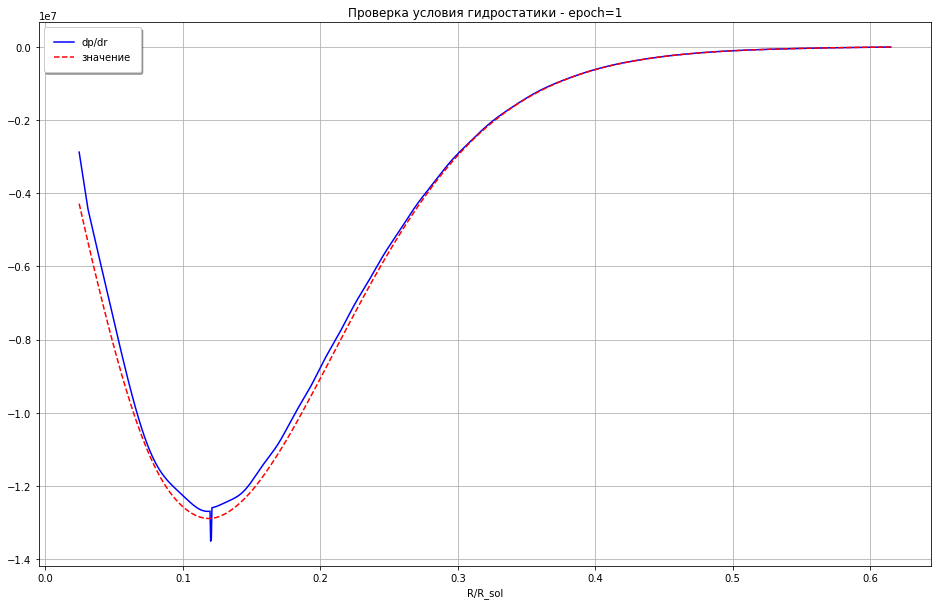

In [111]:
r1 = r[1:-1]/s.R
m1 = m[1:-1]/s.M
a1 = a[1:-1]
da1 = da[1:-1]
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, da1, '-', color='blue', label='dp/dr')
plt.plot(r1, a1, '--', color='red', label='значение')

# plt.xlim(0.,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Проверка условия гидростатики - epoch=%d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

Условие переноса энергии

In [112]:
for i in range(1, dimM-1):
    br[i] = -3/16*k[i]*d[i]*l[i]/ph.sigma/pow(t[i], 3)/4/pi/pow(r[i], 2)
    mu = ph.MU(x[i], 1 - x[i] -Z, Z)
    bc[i] = -0.4*mu/ph.kB*ph.m_prot*ph.G*m[i]/pow(r[i], 2)
    if abs(br[i]) < abs(bc[i]):
        b[i] = br[i]
    else:
        b[i] = bc[i]
    db[i] = (t[i+1] - t[i])/2/(r[i+1] - r[i]) + (t[i] - t[i-1])/2/(r[i] - r[i-1]) # - b[i]
#         db[i] = (t[i] - t[i-1])/(r[i] - r[i-1])
#     print(i, b[i], db[i], pow((b[i] - db[i])/b[i], 2))

In [113]:
db.shape

(1001,)

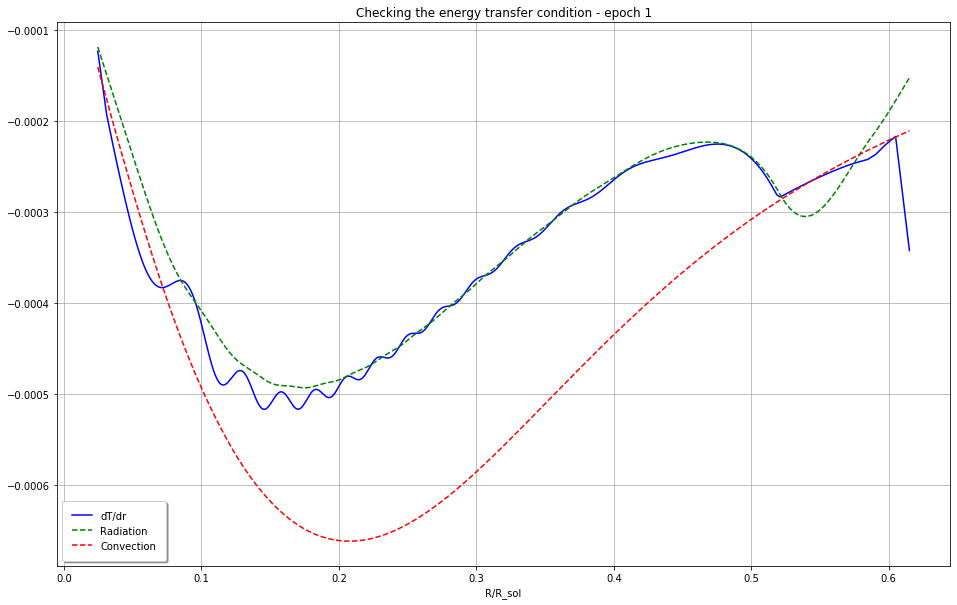

In [114]:
m1 = m[1:-1]/s.M
r1 = r[1:-1]/s.R
b1 = br[1:-1]
b2 = bc[1:-1]
db1 = db[1:-1]
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, db1, '-', color='blue', label='dT/dr')
plt.plot(r1, b1, '--', color='green', label='Radiation')
plt.plot(r1, b2, '--', color='red', label='Convection')
# plt.xlim(0.,.1)
# plt.xlim(0.9,1.01)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Checking the energy transfer condition - epoch %d' % epoch)
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

In [86]:
sa = 0
sb = 0
for i in range(1, dimM-1):
    sa += pow((da[i] - a[i])/a[i], 2)
    sb += pow((db[i] - b[i])/b[i], 2)
sa, sb    

(0.045522718181898694, 1.200604471878696)

In [24]:
# (0.12016591197387155, 0.5811328853706212) - исходгое решение
# (1.028809394773563, 7.761221355954376) - изменили x -> x1
# (1.028809394773563, 3.090175282114637) - d * 1.01
# (0.9083740411486991, 10.104433837309749) d* 1.01 + t * 1.01

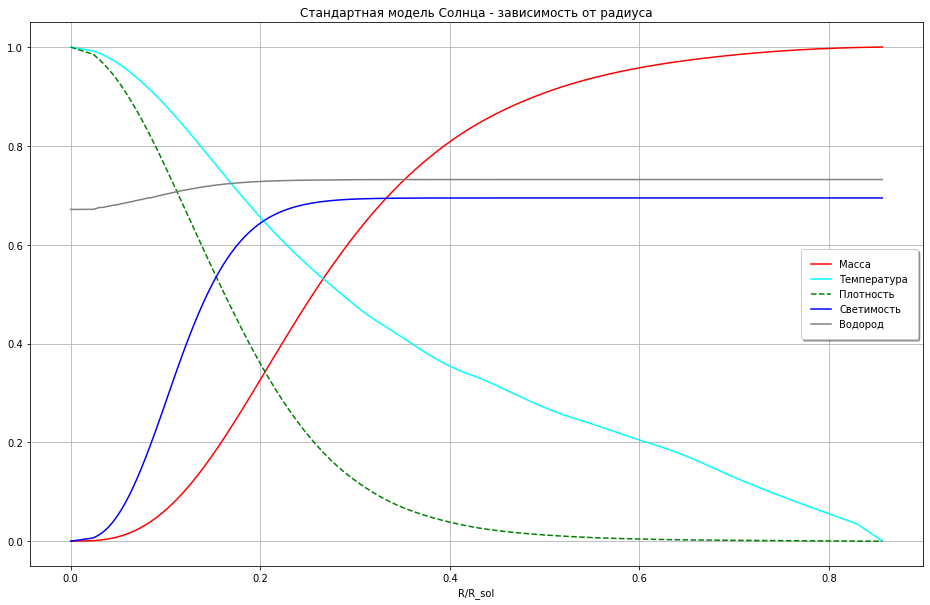

In [46]:
r1 = r/s.R
plt.figure(figsize=(16, 10))
ax = plt.axes()
plt.plot(r1, m/s.M, color='red', label='Масса')
plt.plot(r1, t/t[0], color='cyan', label='Температура')
# plt.plot(r1[1:], d1[1:]/d[0], color='green', label='Плотность')
plt.plot(r1, d/d[0], '--', color='green', label='Плотность')
plt.plot(r1, l/s.L, color='blue', label='Светимость')
plt.plot(r1, x, color='gray', label='Водород')
# plt.plot(r1, p1/p1[0], color='black', marker='.', label='Давление')
# plt.xlim(-0.1,0.1)
# plt.ylim(-0.1, 0.1)
plt.xlabel('R/R_sol')
plt.ylabel('')
plt.title('Стандартная модель Солнца - зависимость от радиуса')
ax.grid(b=True, which='both')

ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);

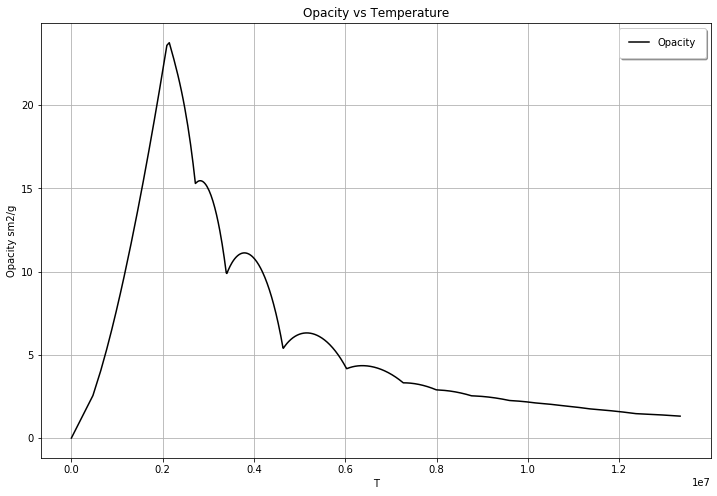

In [59]:
plt.figure(figsize=(12, 8))
ax = plt.axes()
plt.plot(t, k, color='black', label='Opacity')
# plt.plot(r1, myk, color='red', marker='.', label='Непроз my')
#plt.xlim(6, 7.25)
#plt.ylim(0, 20)
plt.xlabel('T')
plt.ylabel('Opacity sm2/g')
plt.title('Opacity vs Temperature')
ax.grid(b=True, which='both')
ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1);